In [1]:
## imports
import pandas as pd
import numpy as np
import plotnine as p9
from plotnine import *
import random

## print multiple things from same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
data = pd.read_pickle("../../data/sentencing_cleaned.pkl")

In [3]:
#3.1

#Filter to Incarceration and remove non-useful sentences
fs_df = data[data.COMMITMENT_TYPE == "Illinois Department of Corrections"]

fs_df = fs_df[(fs_df.COMMITMENT_UNIT != "Dollars") & (fs_df.COMMITMENT_UNIT != "Pounds") & (fs_df.COMMITMENT_UNIT != "Term")]
fs_df.COMMITMENT_UNIT.unique()

#filter down for race
fs_df = fs_df[(fs_df.is_white_derived == True) | (fs_df.is_black_derived == True)]

#make commitment term a float so that you can multiply it to get universal sentence lengths
fs_df.COMMITMENT_TERM = pd.to_numeric(fs_df.COMMITMENT_TERM, downcast = "float")

sentence_translations = [fs_df.COMMITMENT_UNIT == "Year(s)",
                        fs_df.COMMITMENT_UNIT == "Natural Life",
                        fs_df.COMMITMENT_UNIT == "Months",
                        fs_df.COMMITMENT_UNIT == "Days",
                        fs_df.COMMITMENT_UNIT == "Weeks",
                        fs_df.COMMITMENT_UNIT == "Hours"]

code_to = [fs_df.COMMITMENT_TERM*365, 365*(100 - fs_df.age_derived), fs_df.COMMITMENT_TERM*30.5,
           fs_df.COMMITMENT_TERM*1, fs_df.COMMITMENT_TERM*7,
           fs_df.COMMITMENT_TERM*(1/24)]

fs_df["senlength_derived"] = np.select(sentence_translations, code_to, default = 20*365)
fs_df.senlength_derived.head()
fs_df.senlength_derived.describe()

array(['Year(s)', 'Natural Life', 'Months', 'Days', 'Weeks', 'Hours'],
      dtype=object)

9     22630.0
16    25550.0
28     3650.0
32     7300.0
36    16425.0
Name: senlength_derived, dtype: float64

count     58289.000000
mean       1396.720826
std        2062.874778
min           0.000000
25%         366.000000
50%         915.000000
75%        1460.000000
max      147825.000000
Name: senlength_derived, dtype: float64

In [ ]:
## rj comments

## great general job
## small deduction since the head doesn't show an example of each type so it's 
## difficult to spot check

15

   judgeid_derived         variable   value
0        judge_133  black_senlength   488.0
1        judge_166  black_senlength   365.0
2        judge_177  black_senlength   730.0
3         judge_20  black_senlength   730.0
4         judge_21  black_senlength  1460.0
5        judge_279  black_senlength   365.0
6        judge_320  black_senlength   730.0
7        judge_334  black_senlength   730.0
8         judge_35  black_senlength   549.0
9         judge_36  black_senlength   730.0
10        judge_41  black_senlength   365.0
11       judge_133  white_senlength   365.0
12       judge_166  white_senlength   365.0
13       judge_177  white_senlength   365.0
14        judge_20  white_senlength   365.0
15        judge_21  white_senlength   730.0
16       judge_279  white_senlength   365.0
17       judge_320  white_senlength  1095.0
18       judge_334  white_senlength   365.0
19        judge_35  white_senlength   671.0
20        judge_36  white_senlength   457.5
21        judge_41  white_senlen

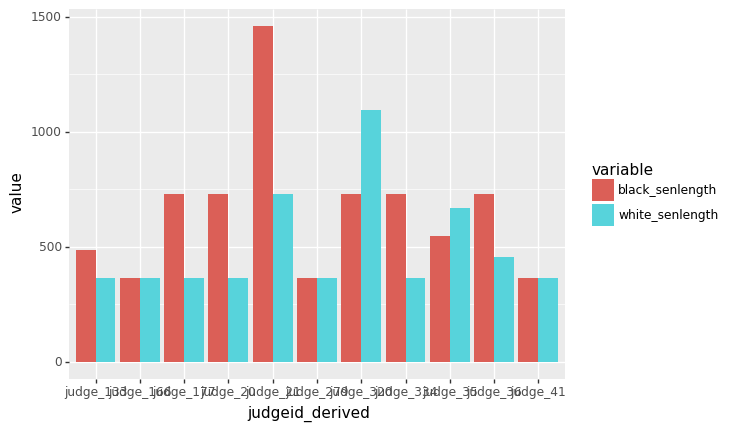

<ggplot: (8768256746219)>

In [4]:
#3.2

fs_df2 = fs_df.reset_index()
fs_df2 = fs_df2[fs_df2.simplified_offense_derived == "Narcotics"].reset_index()
#fs_df2.simplified_offense_derived.unique()
fs_dfb = fs_df2[fs_df2.is_black_derived == True]
fs_dfw = fs_df2[fs_df2.is_white_derived == True]

#find all judges who have presided over 20 narcotics cases involving black defendants
fs_dfb2 = fs_dfb.groupby("judgeid_derived")["is_black_derived"].count().reset_index()
fs_dfb2.columns = ["judgeid_derived", "cases_presided"]
fs_dfb2 = fs_dfb2[fs_dfb2.cases_presided >= 20]
bp_list = fs_dfb2.judgeid_derived.unique().tolist()
#fs_dfb2.head()
#fs_dfb2.cases_presided.describe()

#find all judges who have presided over 20 narcotics cases involving white defendants
fs_dfw2 = fs_dfw.groupby("judgeid_derived")["is_white_derived"].count().reset_index()
fs_dfw2.columns = ["judgeid_derived", "cases_presided"]
fs_dfw2 = fs_dfw2[fs_dfw2.cases_presided >= 20]
wp_list = fs_dfw2.judgeid_derived.unique().tolist()
#print(wp_list)
#fs_dfw2.head()
#fs_dfw2.cases_presided.describe()
len(wp_list)

#get a combined list of judges without duplicates
set_1 = set(wp_list)
set_2 = set(bp_list)
set_3 = set_1 & set_2
judges_list = list(set_3)


#using new judges list, get list of avg senlength by judge for black defendants
fs_dfbj = fs_dfb[fs_dfb.judgeid_derived.isin(judges_list)]
#fs_dfbj.SENTENCE_JUDGE.nunique()
fs_dfbj = fs_dfbj.groupby("judgeid_derived").agg({"senlength_derived": "median"}).reset_index()
fs_dfbj.columns = ["judgeid_derived", "black_senlength"]
#print(fs_dfbj)

#Repeat Process for White Defendants
fs_dfwj = fs_dfw[fs_dfw.judgeid_derived.isin(judges_list)]
#fs_dfwj.SENTENCE_JUDGE.nunique()
fs_dfwj = fs_dfwj.groupby("judgeid_derived").agg({"senlength_derived": "median"}).reset_index()
fs_dfwj.columns = ["judgeid_derived", "white_senlength"]
#print(fs_dfwj)

#Merge two dataframes so they can be graphed
merged_sens = pd.merge(fs_dfbj, fs_dfwj, on = "judgeid_derived")
#print(merged_sens)
merge_melt = pd.melt(merged_sens, id_vars = ["judgeid_derived"],
                     value_vars = ["black_senlength", "white_senlength"])
print(merge_melt)

(p9.ggplot(data = merge_melt, mapping = p9.aes(x = "judgeid_derived", y = "value", fill = "variable"))) + geom_col(position = "dodge")



In [ ]:
## rj comment- great job!
## no deduction but see solutions key for more efficient way that 
## helps avoid the longer approach of (1) splitting into white, counting, filtering
## and (2) splitting into black, counting, filtering
## instead, can use group by to get the counts in one line of code and do filtering after

In [5]:
new_d1 = data[data.COMMITMENT_TYPE == "Illinois Department of Corrections"].reset_index()
new_d1 = new_d1[new_d1.simplified_offense_derived == "Narcotics"].reset_index()
fs_dftw = new_d1[new_d1.judgeid_derived == "judge_21"]
fs_dftw.judgeid_derived.nunique()
fs_dftwn = fs_dftw.copy()

1

In [6]:

store_matches = {}

for i in range(0, fs_dftw.shape[0]):
    
    target_row = fs_dftw.iloc[i]
    
    matches = fs_dftwn[(fs_dftwn.RACE != target_row.RACE) & 
                       (fs_dftwn.GENDER == target_row.GENDER) &
                       (fs_dftwn.age_derived == target_row.age_derived)] 
    
    
    composite = matches.copy()
    composite['target_def_age'] = target_row.age_derived
    store_matches[target_row.CASE_ID] = composite
    #print(target_row.CASE_ID)
all_matches = pd.concat(store_matches)    
## loc out columns I want and clean frame

all_matches = all_matches.loc[:, ("CASE_ID", "RACE", "target_def_age", "GENDER")]
all_matches.head()

##merge dataframe with senlen based on CASEID -- for focal and comp


new_fs = fs_df.loc[:, ("CASE_ID", "senlength_derived")]
new_fs = new_fs[new_fs.CASE_ID.isin(all_matches.CASE_ID)]
all_matches["senlength_derived"] = new_fs[(new_fs.CASE_ID == all_matches.CASE_ID)].senlength_derived


all_matches.head()



CASE_ID                        RACE  target_def_age  \
213700128228 8751   404703573213  White [Hispanic or Latino]            21.0   
             9354   406322205406                       Black            21.0   
386294899533 6876   399913908091                       White            29.0   
             10695  409877997576                       White            29.0   
             12268  414327840987                       Black            29.0   

                   GENDER  
213700128228 8751    Male  
             9354    Male  
386294899533 6876    Male  
             10695   Male  
             12268   Male

ValueError: Can only compare identically-labeled Series objects

In [16]:
## rj note --- close in terms of getting the output from the loop!
## in order to get the other matches merged on, it's giving you
## an error at this line:
## all_matches["senlength_derived"] = new_fs[(new_fs.CASE_ID == all_matches.CASE_ID)].senlength_derived
## because all_matches.CASE_ID is a set of ids 
## and you're checking equality rather than .isin()

## here's a way to merge

### first, add a column for the case id of the focal
focal_ids = [i[0] for i in all_matches.index]
all_matches['caseid_focal'] = focal_ids
all_matches.head()

### add sentence length onto the matches for the non-focal
all_matches_addsentence = pd.merge(all_matches,
                                  new_fs[['CASE_ID', 'senlength_derived']],
                                  on = "CASE_ID",
                                  how = "left")

### see some na for non black or white but fine
all_matches_addsentence.head()

## then, need to merge on the sentence length of the focal
all_matches_addsentence_focal = pd.merge(all_matches_addsentence,
                                        new_fs[['CASE_ID', 'senlength_derived']],
                                        left_on = "caseid_focal",
                                        right_on = "CASE_ID",
                                        suffixes = ["_matches", "focal"])

all_matches_addsentence_focal.head()

## could also do inside the loop in the same
## way you added the target_def_age

CASE_ID                        RACE  target_def_age  \
213700128228 8751   404703573213  White [Hispanic or Latino]            21.0   
             9354   406322205406                       Black            21.0   
386294899533 6876   399913908091                       White            29.0   
             10695  409877997576                       White            29.0   
             12268  414327840987                       Black            29.0   

                   GENDER  caseid_focal  
213700128228 8751    Male  213700128228  
             9354    Male  213700128228  
386294899533 6876    Male  386294899533  
             10695   Male  386294899533  
             12268   Male  386294899533

,CASE_ID,RACE,target_def_age,GENDER,caseid_focal,senlength_derived
0,404703573213,White [Hispanic or Latino],21.0,Male,213700128228,NaN
1,406322205406,Black,21.0,Male,213700128228,1460.0
2,399913908091,White,29.0,Male,386294899533,365.0
3,409877997576,White,29.0,Male,386294899533,365.0
4,414327840987,Black,29.0,Male,386294899533,1460.0


,CASE_ID_matches,RACE,target_def_age,GENDER,caseid_focal,senlength_derived_matches,CASE_IDfocal,senlength_derivedfocal
0,404703573213,White [Hispanic or Latino],21.0,Male,213700128228,NaN,213700128228,1095.0
1,406322205406,Black,21.0,Male,213700128228,1460.0,213700128228,1095.0
2,405812032276,Black,33.0,Male,392395683166,8760.0,392395683166,1825.0
3,412424017021,White [Hispanic or Latino],33.0,Male,392395683166,NaN,392395683166,1825.0
4,407703373595,Black,32.0,Male,396452543476,1460.0,396452543476,2190.0


# Grade

See rubric for specific deductions

- 3.1: 5.5/6 (small deduction for not showing example of each type of sentence)
- 3.2: 2/2 
- 3.3: 3/6 (credit for finding the matches but deduction for not constructing an outcome that allows us to compare a focal defendant's sentence length with lengths of their matches)

Raw score: 10.5

Scaled score: 12